In [9]:
import pandas as pd

df = pd.read_csv(r"C:\Users\jenny.kim-es\Downloads\CI_Logarithmic.csv")

print(df)

    Reflectance     Mean
0           0.2    3.062
1           0.5   15.562
2           1.0   19.498
3           5.0   62.772
4           8.0   85.663
5           9.9   98.565
6           0.4    6.055
7           1.0   22.854
8           2.0   31.086
9          10.0  100.074
10         16.0  132.429
11         19.8  150.154
12          0.6    9.429
13          1.5   31.121
14          3.0   43.374
15         15.0  130.865
16         24.0  166.587
17         29.7  183.187
18          0.8   11.772
19          2.0   38.550
20          4.0   54.426
21         20.0  153.125
22         32.0  187.451
23         39.6  203.882
24          1.0   13.972
25          2.5   46.575
26          5.0   63.597
27         25.0  170.119
28         40.0  204.194
29         49.5  218.786
30          1.2   15.879
31          3.0   53.129
32          6.0   72.732
33         30.0  185.071
34         48.0  215.043
35         59.4  229.854
36          1.4   17.582
37          3.5   60.474
38          7.0   80.216


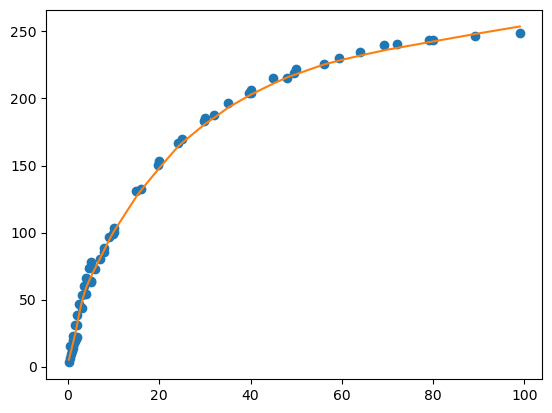

0.9975911284624963
72.38274197447873


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import statsmodels.api as sm

# introduce some floats in our x-values
x = df['Reflectance']
y = df['Mean']

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.3) #fit a line of 30% of window

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(1000)] #0.1 x 1000 = 100

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)

plt.plot(x, y, 'o')
#plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.savefig('lowess.jpg')
plt.show()
y_pred=f(x)
r1, pvalue = pearsonr(df['Mean'], y_pred)
r2 = r1 *r1
#g=sns.regplot(data=df, x='Reflectance', y='Mean', logx=True, ci=90, label=f'R^2 = {r2:.5f}')
#g.legend()

#print(sorted(df['Mean']), lowess_y)
print(r2)
print(f(5.8)) #use function here to get mean values 
#print({'x':xnew,'y':ynew})


In [12]:
# Now create a bootstrap confidence interval around the a LOWESS fit

import numpy as np
def lowess_with_confidence_bounds(
    x, y, eval_x, N=200, conf_interval=0.90, lowess_kw=None
):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


# Compute the 95% confidence interval
eval_x = np.linspace(0, 100, 1000)
smoothed, bottom, top = lowess_with_confidence_bounds(
    x, y, eval_x, lowess_kw={"frac": 0.3}
)


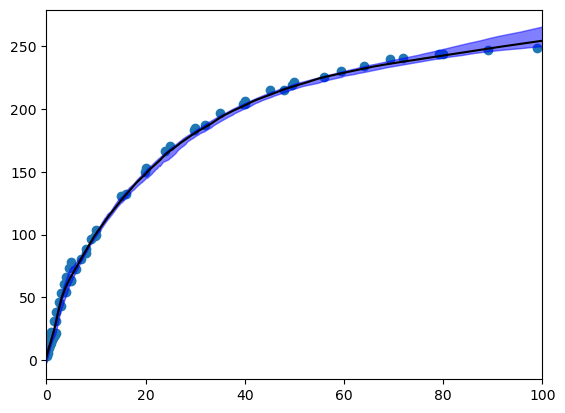

In [13]:
# Plot the confidence interval and fit
import pylab
fig, ax = pylab.subplots()
ax.scatter(x, y)
ax.plot(eval_x, smoothed, c="k")
ax.fill_between(eval_x, bottom, top, alpha=0.5, color="b")
pylab.autoscale(enable=True, axis="x", tight=True)
plt.savefig('lowess_ci.jpg')

In [12]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from moepy import lowess

# Data generation
x = df['Reflectance']
y = df['Mean']

# Model fitting
lowess_model = lowess.Lowess()
lowess_model.fit(x, y)

# Model prediction
x_pred = np.linspace(0, 100, 1000)
y_pred = lowess_model.predict(x_pred)

# Plotting
plt.plot(x_pred, y_pred, '--', label='LOWESS', color='k', zorder=3)
plt.scatter(x, y, label='Noisy Sin Wave', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

AttributeError: 'Series' object has no attribute 'reshape'

<Axes: xlabel='Reflectance', ylabel='Mean'>

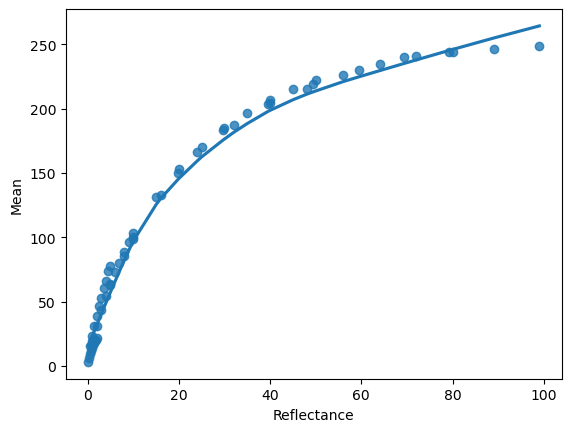

In [4]:
import seaborn as sns
sns.regplot(data=df, x="Reflectance", y="Mean", lowess=True, ci=90)